The purposes of this notebook are:

* Analyze data from california housing dataset with plots and on interactives Leaflet.js maps using Folium.
* Employment of Auto machine learning tool TPOT to optimize the regressor used to predict house prices. In this case the resulting pipeline of TPOT proposes a XGBoost Regressor which is implemented later.

It is possible to interact with the maps of this jupyter notebook using nbviewer in the following link:

http://nbviewer.jupyter.org/github/alvertogit/datascience/blob/master/Geospatial%20analysis%20TPOT%20XGBoost%20california%20housing.ipynb


**Data Set Characteristics:**

Number of Instances: 20640

Number of Attributes: 8 numeric, predictive attributes and the target

Attribute Information:
- MedInc        median income in block
- HouseAge      median house age in block
- AveRooms      average number of rooms
- AveBedrms     average number of bedrooms
- Population    block population
- AveOccup      average house occupancy
- Latitude      house block latitude
- Longitude     house block longitude

Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/
The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S.

Census Bureau publishes sample data (a block group typically has a population\nof 600 to 3,000 people).

References
- Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,Statistics and Probability Letters, 33 (1997) 291-297

In [1]:
from sklearn.datasets import fetch_california_housing # california housing dataset
from sklearn import metrics

from tpot import TPOTRegressor
import xgboost as xgb # extreme gradient boosting
#from tpot import TPOTClassifier
from xgboost import XGBRegressor
import seaborn as sns # statistical data visualization
import matplotlib.pyplot as plt # plotting
import folium # interactive map
import pandas as pd # data structures
import numpy as np # linear algebra, arrays

In [2]:
dataset = fetch_california_housing()

In [3]:
feature_names = dataset.feature_names
print(feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Split data into training (75%) and testing (25%)

In [4]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(dataset.data,
                                                                            dataset.target,
                                                                            test_size=0.25,
                                                                            random_state=4)

**Data analysis**

In [5]:
print(train_features.shape)
print(train_labels.shape)

(15480, 8)
(15480,)


In [6]:
print("Train labels range: {0} - {1}".format(min(train_labels),max(train_labels)))

Train labels range: 0.14999 - 5.00001


In [7]:
print(test_features.shape)
print(test_labels.shape)

(5160, 8)
(5160,)


House distribution based on location

<Figure size 720x720 with 0 Axes>

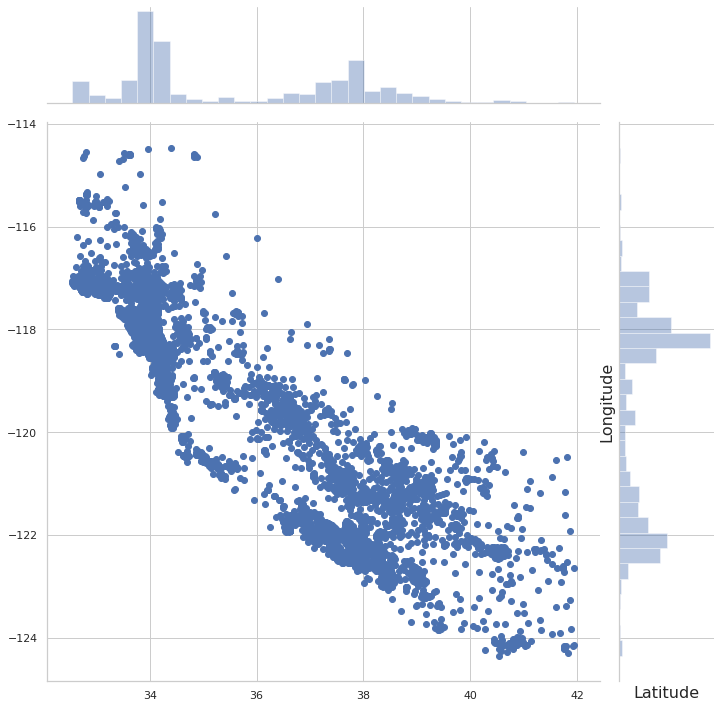

In [8]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,10))
sns.jointplot(x=train_features[:,6],
              y=train_features[:,7],
              height=10)
plt.ylabel('Longitude', fontsize=16)
plt.xlabel('Latitude', fontsize=16)
plt.show()

Interactive heatmap with folium needs some data preparation

In [9]:
heat_data = [[train_features[i][6], train_features[i][7]] for i in range(len(train_features))]

California housing interactive heatmap based on location

In [10]:
from folium.plugins import HeatMap

california_heat_map = folium.Map([37, -120], 
                        tiles='stamentoner', 
                        zoom_start=6)

HeatMap(heat_data, radius= 14).add_to(california_heat_map)

california_heat_map

Housing analysis based on location, price and population (circles radius)

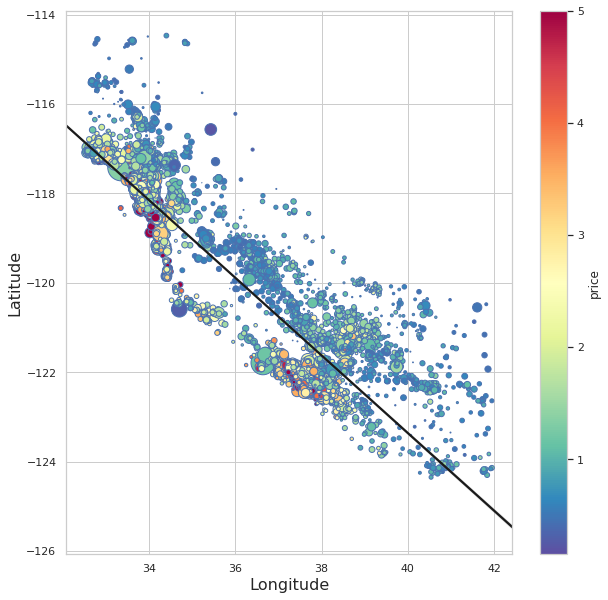

In [11]:
plt.figure(figsize=(10,10))
points = plt.scatter(x=train_features[:,6], 
                     y=train_features[:,7],
                     s=train_features[:,4]/50,
                     c=train_labels, cmap='Spectral_r', edgecolors='b') # set style options

plt.colorbar(points, label='price') # add a color bar
sns.regplot(x=train_features[:,6],
            y=train_features[:,7], 
            scatter=False, color='.1')
plt.ylabel('Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=16)
plt.show()

Interactive housing map for 1000 train samples using circles

Color circles go from blue (lower prices) to red (higher prices)

In [12]:
train_labels_color = pd.cut(train_labels, bins=5, 
                            labels=['blue','green','yellow','orange','red'])

Circles properties provide additional information for price (color) and population (radius)

In [13]:
california_prices_map = folium.Map([36, -120], 
                        tiles='stamenterrain', 
                        zoom_start=7)

# create feature group
fg = folium.FeatureGroup(name='housing locations')

# drawing 1000 samples
for i in range(1000):
    my_Circle=folium.CircleMarker(location=[train_features[i][6],train_features[i][7]],
                                  radius=train_features[i][4]/400,
                                  fill=True,
                                  color=train_labels_color[i],
                                  fill_opacity=0.7)
    fg.add_child(my_Circle)

california_prices_map.add_child(fg)

Population and coast proximity affect prices

Employ TPOT for Auto machine learning to optimize pipeline using genetic programming

In [18]:
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, n_jobs=2) # 2 CPU cores, -1 all cores
tpot.fit(train_features,train_labels)

Generation 1 - Current best internal CV score: -0.2307986072466015
Generation 2 - Current best internal CV score: -0.2307986072466015
Generation 3 - Current best internal CV score: -0.22005721933578518
Generation 4 - Current best internal CV score: -0.22005721933578518
Generation 5 - Current best internal CV score: -0.22005721933578518

Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=7, n_estimators=100, nthread=1, subsample=0.8)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=5,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=2, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=50,
       random_state=None, scoring=None, subsample=1.0, use_dask=False,
       verbosity=2, warm_start=False)

Calculate pipeline score

In [19]:
print(tpot.score(test_features,test_labels))

-0.2183455206241019


It is negative because for regression scoring tpot uses 'neg_mean_squared_error'

Export tpot pipeline to a file

In [20]:
tpot.export('tpot_california_pipeline.py')

True

The exported pipeline proposes a XGBoost Regressor model:

```python
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:-0.22005721933578518
exported_pipeline = XGBRegressor(learning_rate=0.1, max_depth=9, min_child_weight=7, n_estimators=100, nthread=1, subsample=0.8)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
```

Wrap train and test features into dataframes to have available feature column names

In [38]:
train_features_df = pd.DataFrame(train_features, columns=feature_names)
test_features_df  = pd.DataFrame(test_features, columns=feature_names)

Define and fit XGBRegressor model

In [39]:
model = XGBRegressor(learning_rate=0.1, max_depth=9, min_child_weight=7, n_estimators=100, nthread=1, subsample=0.8)
model.fit(train_features_df, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

Get predictions for test dataset

In [40]:
predictions = model.predict(test_features_df)

In [41]:
predictions[:10]

array([1.5835694, 2.8150349, 1.1606382, 1.1668639, 3.646655 , 0.8692231,
       2.2264996, 4.1691575, 1.3036488, 1.1071885], dtype=float32)

In [42]:
test_labels[:10]

array([1.752  , 3.147  , 0.9    , 1.231  , 3.509  , 0.873  , 2.127  ,
       5.00001, 1.375  , 1.107  ])

Calculate model mean squared error for test dataset

In [43]:
np.sqrt(metrics.mean_squared_error(predictions, test_labels))

0.46727456663518707

Plot model features importance

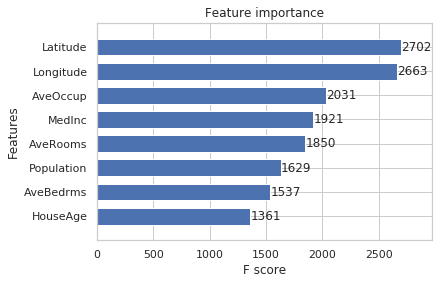

In [44]:
xgb.plot_importance(model, height=0.7) 

It shows that location coordinates of houses are the most relevant features to estimate prices